<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter4/src/text_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# テキスト分類のタスクを実行
### 使用するデータセットの参考文献
 - https://www.rondhuit.com/download.html#ldcc

## Google colabを使用の場合、ランタイムのタブから「ランタイムのタイプを変更」→ハードウェアアクセラレータと進み、T4 GPUを選択

In [1]:
# 以下のコマンドでGPUが使用可能かを確認
! nvidia-smi

Fri Jan 24 12:19:22 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## データセットのダウンロード
 - https://www.rondhuit.com/download.html#ldcc からldcc-20140209.tar.gzをダウンロード

## Google Colabの準備

In [2]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [9]:
# Google Colabのファイルをクリックし、ldcc-20140209.tar.gzをドラッグ＆ドロップしてアップロード
# ldcc-20140209.tar.gzrを以下のコマンドで解凍する
!mv ldcc-20140209.tar.gz ldcc-20140209.tar
!tar xvf ldcc-20140209.tar > /dev/null

In [10]:
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

## ライブラリをインポート

In [5]:
! pip install scikit-learn==1.3.2 #ライブラリのverによっては次元圧縮の挙動が異なることがあるため注意
! pip install numpy==1.26.4
! pip install pandas==2.2.2
! pip install umap-learn==0.5.5
!pip install fugashi #"tohoku-nlp/bert-base-japanese-char"の駆動に必要
!pip install ipadic #"tohoku-nlp/bert-base-japanese-char"の駆動に必要
!pip install unidic_lite #"tohoku-nlp/bert-base-japanese-char"の駆動に必要

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 95.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86834 sha256=2c90131bc1a99e2d79dd126aeb000e75909a1b188a4c06ee08284341022e3c24
  Stored in directory: /root/.cache/pip/wheels/de/07/2e/814a6ee82e37528f2044a609a431028375b149bc31f03c0e27
Successfully built umap-learn
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.0/698.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 78.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.

In [11]:
import gc
import glob
import os

import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import umap
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

## グラフ表示の際のフォント種類やフォントサイズを設定

In [12]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20

## データを読み込み、データフレームに格納

In [25]:
# ファイルの読み込みの関数
def read_file(file_path):
    with open(file_path, "r") as f:
        text = f.read()
    return text


# 1フォルダの読み込みの関数
def read_folder(folder_path):
    files = glob.glob(folder_path + "/*.txt")
    texts = [read_file(file) for file in files]
    return texts


# 複数フォルダの読み込みの関数
def read_folders(folder_paths):
    texts = [read_folder(folder_path) for folder_path in folder_paths]
    return texts


# フォルダのパスを取得
folder_paths = glob.glob(INPUT_FILE_PATH + "text/*")

# フォルダごとにデータフレームを作成
dfs = []
for folder_path in tqdm(folder_paths):
    folder_name = os.path.basename(folder_path)
    texts = read_folder(folder_path)
    df = pd.DataFrame({"text": texts, "label": folder_name})
    dfs.append(df)

# 各データフレームを結合
df = pd.concat(dfs, ignore_index=True)

# labelごとのデータ数を確認
print(df["label"].value_counts())

  0%|          | 0/11 [00:00<?, ?it/s]

label
sports-watch      901
smax              871
it-life-hack      871
movie-enter       871
dokujo-tsushin    871
kaden-channel     865
peachy            843
topic-news        771
livedoor-homme    512
Name: count, dtype: int64


In [26]:
df

,text,label
0,http://news.livedoor.com/article/detail/659004...,smax
1,http://news.livedoor.com/article/detail/691364...,smax
2,http://news.livedoor.com/article/detail/659313...,smax
3,http://news.livedoor.com/article/detail/674942...,smax
4,http://news.livedoor.com/article/detail/660754...,smax
...,...,...
7371,http://news.livedoor.com/article/detail/640634...,sports-watch
7372,http://news.livedoor.com/article/detail/645322...,sports-watch
7373,http://news.livedoor.com/article/detail/467896...,sports-watch
7374,http://news.livedoor.com/article/detail/463002...,sports-watch


In [27]:
df["text"][0]

'http://news.livedoor.com/article/detail/6590044/\n2012-05-24T12:55:00+0900\nソニー、Sony TabletシリーズをAndroid 4.0にOSバージョンアップするソフトウェアアップデートを提供開始\n本日24日13時から提供開始！ \n\nソニーは18日、同社のAndroid搭載タブレット「Sony Tablet」シリーズにおいて最新プラットフォーム「Android 4.0（開発コード名：IceCream Sandwich；ICS）」へOSバージョンアップするためのシステムソフトウェアアップデートを2012年5月24日（木）13：00から提供開始すると発表しています。\n\n今回のアップデートは、Sony Tablet SシリーズおよびSony Tablet Pシリーズを対象に、OSをAndroid 4.0.3へバージョンアップします。当初は4月下旬に予定されていましたが、ソフトウェア開発に時間を要するとして4月27日に延期することが発表されていました。\n\nOSバージョンアップ以外にも“Sony Tablet”独自の機能が追加されるとのことです。\n\n\n\n主なアップデート内容は以下の通り。\n\n＜Android 4.0.3に伴う機能追加＞\n\n1. 最新版のAndroid 4.0.3にアップデートされることにより、Android 4.0対応スマートフォンとユーザーインターフェースが共通化します。\n2. ロック画面からのカメラの直接起動やパノラマ写真の撮影、「ギャラリー」アプリケーションで画像の編集が可能になるなど、写真・動画についての機能が向上します。\n\n\n＜“Sony Tablet”独自の機能追加＞\n1. ソニー製BDレコーダー※1と連携してテレビ番組の視聴が可能\nソニー製のBDレコーダー※1で録画した番組や放送中の番組を“Sony Tablet”上で視聴することが可能になります。家庭内のネットワークに接続することで、テレビのない寝室やキッチン、書斎など、場所を選ばず家中でテレビ番組をハイビジョン（720p）で楽しむことができます。\n新しくソニーが提供するアプリケーション「RECOPLA（レコプラ）」※3を、“Sony Tablet”上の「Select Ap

## データの前処理

In [28]:
# df['text']の文章からhttps://～を削除する
df["text"] = df["text"].str.replace(
    "https?://[\w/:%#\$&\?\(\)~\.=\+\-]+", "", regex=True
)
df

,text,label
0,\n2012-05-24T12:55:00+0900\nソニー、Sony Tabletシリー...,smax
1,\n2012-09-03T07:55:00+0900\nAndroid 4.1 Jelly ...,smax
2,\n2012-05-25T09:55:00+0900\n本日発売開始！au初Android ...,smax
3,\n2012-07-12T09:25:00+0900\n本日発売開始のカメラ重視スマホ大本命...,smax
4,\n2012-05-30T07:55:00+0900\nSoftBank 4GとULTRA ...,smax
...,...,...
7371,\n2012-03-28T09:00:00+0900\nノムさん、佐々木則夫監督に「50、6...,sports-watch
7372,\n2012-04-10T11:05:00+0900\n「自分で言っちゃった」川澄が明かす、...,sports-watch
7373,\n2010-03-25T13:00:00+0900\n【Sports Watch】人気ジョ...,sports-watch
7374,\n2010-02-28T14:30:00+0900\n【Sports Watch】安藤美姫...,sports-watch


In [29]:
# df['text']の文章から改行コードを削除する
df["text"] = df["text"].str.replace("\n", "", regex=True)
df

,text,label
0,2012-05-24T12:55:00+0900ソニー、Sony TabletシリーズをAn...,smax
1,2012-09-03T07:55:00+0900Android 4.1 Jelly Bean...,smax
2,2012-05-25T09:55:00+0900本日発売開始！au初Android 4.0ス...,smax
3,2012-07-12T09:25:00+0900本日発売開始のカメラ重視スマホ大本命！新ブラ...,smax
4,2012-05-30T07:55:00+0900SoftBank 4GとULTRA SPEE...,smax
...,...,...
7371,2012-03-28T09:00:00+0900ノムさん、佐々木則夫監督に「50、60はハナ...,sports-watch
7372,2012-04-10T11:05:00+0900「自分で言っちゃった」川澄が明かす、遅咲きの...,sports-watch
7373,2010-03-25T13:00:00+0900【Sports Watch】人気ジョッキー・...,sports-watch
7374,2010-02-28T14:30:00+0900【Sports Watch】安藤美姫“日本の...,sports-watch


## Transformer系列のモデルを用いたベクトル化を行う

In [30]:
# https://huggingface.co/tohoku-nlp/bert-base-japanese-charを使用して文章のベクトル化を行う

# モデルの読み込み
model = SentenceTransformer("tohoku-nlp/bert-base-japanese-char")

# ベクトル化
vectors = model.encode(df["text"].values, show_progress_bar=True)

Batches:   0%|          | 0/231 [00:00<?, ?it/s]

In [31]:
# vectorsをデータフレームに変換
vectors_df = pd.DataFrame(vectors)
vectors_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.193050,-0.013387,-0.185839,-0.080459,0.082417,0.262580,-0.273127,0.010066,0.183952,0.115116,...,-0.101448,0.143205,-0.023514,-0.188712,0.262483,-0.090910,0.180547,0.144480,0.154097,-0.165864
1,0.033231,-0.080298,-0.195657,-0.095155,0.104828,0.251636,-0.417375,0.119592,0.157941,0.082951,...,0.020977,0.183001,-0.071242,-0.096732,0.325338,-0.037086,0.080959,0.047797,0.052189,-0.045529
2,0.099054,-0.007491,-0.188740,-0.147804,-0.004734,0.269469,-0.335622,0.134673,0.219147,0.083186,...,-0.014379,0.115580,-0.076674,-0.010639,0.370676,-0.142664,0.200507,0.110243,0.144470,-0.100476
3,0.064369,-0.015771,-0.193808,-0.111716,0.042445,0.232585,-0.450262,0.146204,0.239691,0.105059,...,0.011281,0.210132,-0.071211,-0.068750,0.275281,-0.084245,0.189852,0.049627,0.091972,-0.181332
4,0.050928,-0.001671,-0.193965,-0.083126,0.060823,0.308739,-0.192817,0.085603,0.238460,0.081870,...,-0.078983,0.120836,-0.058913,-0.129581,0.375670,-0.182621,0.269845,0.085031,0.111687,-0.201511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7371,-0.042413,0.049927,0.057570,-0.002107,-0.029095,0.151832,-0.476960,0.129566,0.136683,-0.141045,...,-0.149545,0.052670,0.185243,-0.014078,0.218234,-0.103919,0.033799,0.043124,-0.074170,-0.096593
7372,-0.009258,-0.008148,0.039939,-0.081376,-0.154786,0.262907,-0.500803,0.163272,0.162697,-0.105188,...,-0.074575,0.107899,0.159328,-0.043396,0.124662,0.053365,-0.039874,0.025576,-0.023798,0.032906
7373,-0.046887,-0.066416,0.075315,-0.046215,0.057952,0.287757,-0.426764,0.240982,0.133979,-0.020312,...,-0.012198,0.027439,0.223808,-0.127529,0.119437,0.032701,-0.072340,0.005725,-0.091415,-0.029084
7374,-0.029813,-0.016438,0.045314,-0.033497,-0.105650,0.329748,-0.462399,0.134894,0.282303,-0.011034,...,0.049538,0.012722,0.181986,0.013219,0.194335,-0.057789,-0.128075,0.002044,-0.114909,-0.061308


## ベクトル化したテキストデータをUMAPを用いて2次元空間に可視化する

In [32]:
# dfとvectors_dfを結合
df = pd.concat([df, vectors_df], axis=1)
df

,text,label,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,2012-05-24T12:55:00+0900ソニー、Sony TabletシリーズをAn...,smax,0.193050,-0.013387,-0.185839,-0.080459,0.082417,0.262580,-0.273127,0.010066,...,-0.101448,0.143205,-0.023514,-0.188712,0.262483,-0.090910,0.180547,0.144480,0.154097,-0.165864
1,2012-09-03T07:55:00+0900Android 4.1 Jelly Bean...,smax,0.033231,-0.080298,-0.195657,-0.095155,0.104828,0.251636,-0.417375,0.119592,...,0.020977,0.183001,-0.071242,-0.096732,0.325338,-0.037086,0.080959,0.047797,0.052189,-0.045529
2,2012-05-25T09:55:00+0900本日発売開始！au初Android 4.0ス...,smax,0.099054,-0.007491,-0.188740,-0.147804,-0.004734,0.269469,-0.335622,0.134673,...,-0.014379,0.115580,-0.076674,-0.010639,0.370676,-0.142664,0.200507,0.110243,0.144470,-0.100476
3,2012-07-12T09:25:00+0900本日発売開始のカメラ重視スマホ大本命！新ブラ...,smax,0.064369,-0.015771,-0.193808,-0.111716,0.042445,0.232585,-0.450262,0.146204,...,0.011281,0.210132,-0.071211,-0.068750,0.275281,-0.084245,0.189852,0.049627,0.091972,-0.181332
4,2012-05-30T07:55:00+0900SoftBank 4GとULTRA SPEE...,smax,0.050928,-0.001671,-0.193965,-0.083126,0.060823,0.308739,-0.192817,0.085603,...,-0.078983,0.120836,-0.058913,-0.129581,0.375670,-0.182621,0.269845,0.085031,0.111687,-0.201511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7371,2012-03-28T09:00:00+0900ノムさん、佐々木則夫監督に「50、60はハナ...,sports-watch,-0.042413,0.049927,0.057570,-0.002107,-0.029095,0.151832,-0.476960,0.129566,...,-0.149545,0.052670,0.185243,-0.014078,0.218234,-0.103919,0.033799,0.043124,-0.074170,-0.096593
7372,2012-04-10T11:05:00+0900「自分で言っちゃった」川澄が明かす、遅咲きの...,sports-watch,-0.009258,-0.008148,0.039939,-0.081376,-0.154786,0.262907,-0.500803,0.163272,...,-0.074575,0.107899,0.159328,-0.043396,0.124662,0.053365,-0.039874,0.025576,-0.023798,0.032906
7373,2010-03-25T13:00:00+0900【Sports Watch】人気ジョッキー・...,sports-watch,-0.046887,-0.066416,0.075315,-0.046215,0.057952,0.287757,-0.426764,0.240982,...,-0.012198,0.027439,0.223808,-0.127529,0.119437,0.032701,-0.072340,0.005725,-0.091415,-0.029084
7374,2010-02-28T14:30:00+0900【Sports Watch】安藤美姫“日本の...,sports-watch,-0.029813,-0.016438,0.045314,-0.033497,-0.105650,0.329748,-0.462399,0.134894,...,0.049538,0.012722,0.181986,0.013219,0.194335,-0.057789,-0.128075,0.002044,-0.114909,-0.061308


In [33]:
# dfのvector列をUMAPを使って次元削減

# UMAP
umap_model = umap.UMAP(n_components=2, random_state=42) # n_neighborsのデフォルト値は15
umap_result = umap_model.fit_transform(vectors)

# UMAPの結果をデータフレームに変換
umap_df = pd.DataFrame(umap_result, columns=["umap1", "umap2"])

# dfとumap_dfを結合
df = pd.concat([df, umap_df], axis=1)
df

,text,label,0,1,2,3,4,5,6,7,...,760,761,762,763,764,765,766,767,umap1,umap2
0,2012-05-24T12:55:00+0900ソニー、Sony TabletシリーズをAn...,smax,0.193050,-0.013387,-0.185839,-0.080459,0.082417,0.262580,-0.273127,0.010066,...,-0.023514,-0.188712,0.262483,-0.090910,0.180547,0.144480,0.154097,-0.165864,7.210486,8.205619
1,2012-09-03T07:55:00+0900Android 4.1 Jelly Bean...,smax,0.033231,-0.080298,-0.195657,-0.095155,0.104828,0.251636,-0.417375,0.119592,...,-0.071242,-0.096732,0.325338,-0.037086,0.080959,0.047797,0.052189,-0.045529,5.479242,7.302757
2,2012-05-25T09:55:00+0900本日発売開始！au初Android 4.0ス...,smax,0.099054,-0.007491,-0.188740,-0.147804,-0.004734,0.269469,-0.335622,0.134673,...,-0.076674,-0.010639,0.370676,-0.142664,0.200507,0.110243,0.144470,-0.100476,5.623517,7.774847
3,2012-07-12T09:25:00+0900本日発売開始のカメラ重視スマホ大本命！新ブラ...,smax,0.064369,-0.015771,-0.193808,-0.111716,0.042445,0.232585,-0.450262,0.146204,...,-0.071211,-0.068750,0.275281,-0.084245,0.189852,0.049627,0.091972,-0.181332,5.691489,7.770709
4,2012-05-30T07:55:00+0900SoftBank 4GとULTRA SPEE...,smax,0.050928,-0.001671,-0.193965,-0.083126,0.060823,0.308739,-0.192817,0.085603,...,-0.058913,-0.129581,0.375670,-0.182621,0.269845,0.085031,0.111687,-0.201511,5.851479,8.145267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7371,2012-03-28T09:00:00+0900ノムさん、佐々木則夫監督に「50、60はハナ...,sports-watch,-0.042413,0.049927,0.057570,-0.002107,-0.029095,0.151832,-0.476960,0.129566,...,0.185243,-0.014078,0.218234,-0.103919,0.033799,0.043124,-0.074170,-0.096593,12.982304,0.683562
7372,2012-04-10T11:05:00+0900「自分で言っちゃった」川澄が明かす、遅咲きの...,sports-watch,-0.009258,-0.008148,0.039939,-0.081376,-0.154786,0.262907,-0.500803,0.163272,...,0.159328,-0.043396,0.124662,0.053365,-0.039874,0.025576,-0.023798,0.032906,12.616163,0.357569
7373,2010-03-25T13:00:00+0900【Sports Watch】人気ジョッキー・...,sports-watch,-0.046887,-0.066416,0.075315,-0.046215,0.057952,0.287757,-0.426764,0.240982,...,0.223808,-0.127529,0.119437,0.032701,-0.072340,0.005725,-0.091415,-0.029084,9.484053,0.956906
7374,2010-02-28T14:30:00+0900【Sports Watch】安藤美姫“日本の...,sports-watch,-0.029813,-0.016438,0.045314,-0.033497,-0.105650,0.329748,-0.462399,0.134894,...,0.181986,0.013219,0.194335,-0.057789,-0.128075,0.002044,-0.114909,-0.061308,12.568093,-0.010377


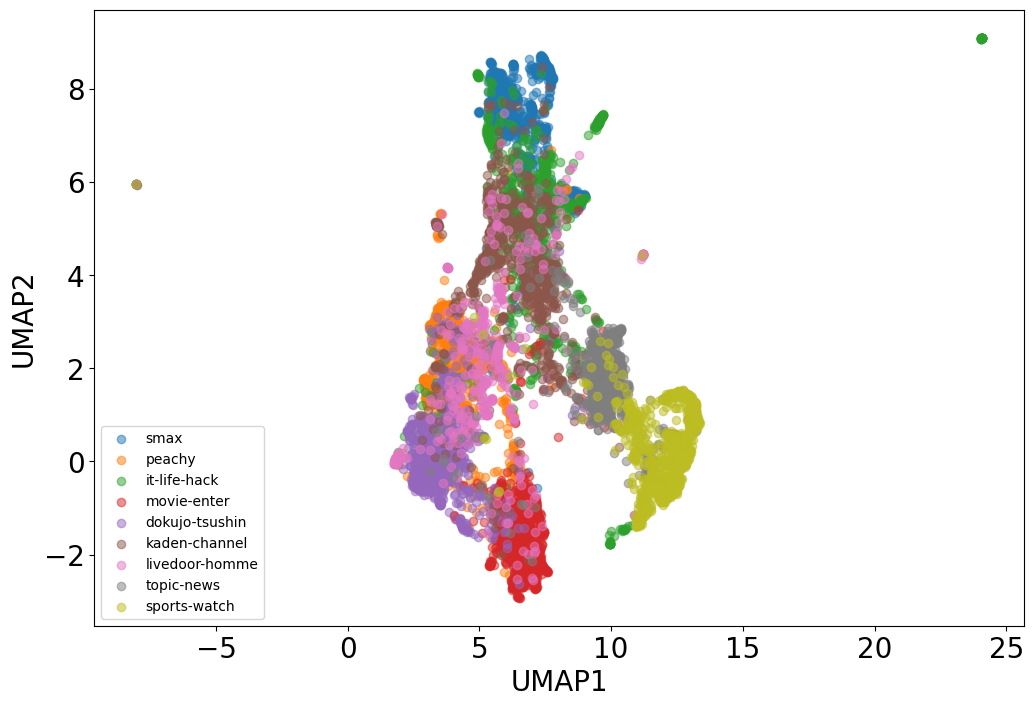

In [34]:
# umap1とumap2をプロット、labelごとに色分けして透過度を変える
plt.figure(figsize=(12, 8))
for label in df["label"].unique():
    plt.scatter(
        df[df["label"] == label]["umap1"],
        df[df["label"] == label]["umap2"],
        label=label,
        alpha=0.5,
    )
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(fontsize=10)
plt.show()

## 実行環境のライブラリverを保存

In [35]:
!pip freeze > requirements_text_clustering.txt

In [36]:
from google.colab import files

files.download('requirements_text_clustering.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>